# Analisi delle varianti di Rprop per la classificazione del dataset MNIST

## Introduzione

In questo quaderno, esploreremo le prestazioni di diverse varianti dell'algoritmo di ottimizzazione Rprop (Resilient Backpropagation) applicate alla classificazione del famoso dataset MNIST. Il dataset MNIST è un insieme di immagini di cifre scritte a mano, ampiamente utilizzato come benchmark nell'ambito dell'apprendimento automatico e del riconoscimento di pattern.

## Obiettivo

L'obiettivo principale di questo studio è valutare le prestazioni di diverse varianti di Rprop nell'addestramento di reti neurali artificiali per la classificazione del dataset MNIST. In particolare, esploreremo:

- Rprop standard (Rprop-)
- Rprop con backtracking dei pesi (Rprop+)
- Improved Rprop (iRprop-)
- Improved Rprop con backtracking dei pesi (iRprop+)

Per ciascuna variante di Rprop, addestreremo una rete neurale artificiale originaria e ne valuteremo le prestazioni attraverso grafici che mostrano l'andamento dell'errore e della precisione sia sul set di addestramento che sul set di validazione. Infine, testeremo le reti addestrate su un set di test e visualizzeremo le probabilità predette per alcune immagini del dataset.

## Contenuti

1. Estrazione e preparazione del dataset MNIST
2. Creazione della rete neurale originaria
3. Addestramento delle reti neurali con diverse varianti di Rprop
4. Valutazione delle prestazioni attraverso grafici
5. Test delle reti addestrate su nuove immagini
6. Conclusioni e osservazioni finali


In [1]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds

import numpy as np
import pandas as pd

# Lettura csv con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

# Ottenimento array per il training e il testing
train_array = np.array(train_data)
test_array = np.array(test_data)

# Estrapoliamo il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

# Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcolo percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

# Distribuzione training, validation e test set
train_in, train_labels = ds.get_mnist_training(train_array, val_index)
validation_in, validation_labels = ds.get_mnist_validation(train_array, val_index)
test_in, test_labels = ds.get_mnist_testing(test_array)

# Creazione rete neurale

# Assegnazione funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.tanh]

# Assegnazione numero di neuroni per ogni strato
hidden_layers = [20]
#Assegnazione della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

# Estrazione input e target
input_layer_size = train_in.shape[0]
output_layer_size = train_labels.shape[0]
net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)

epochs = 10
learning_rate = 0.00001

# Copia la rete principale in quattro per il training
std_training_net = net.duplicate_network()
plus_training_net = net.duplicate_network()
istd_training_net = net.duplicate_network()
iplus_training_net = net.duplicate_network()

std_training_net.get_net_structure()

Numero di strati nascosti: 1
Dimensione dell'input: 784
Dimensione dell'output: 10
Neuroni negli strati nascosti: 20
Funzioni di attivazione: tanh, identity
Funzione di errore: cross_entropy_softmax


In [2]:
from uninaannpy.neural_network import RpropType

# Batch training Rprop standard
std_train_err, std_validation_err, std_train_accuracy, std_validation_accuracy = std_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.STANDARD)


Epoca: 0/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 12.96694%,
    Validation Accuracy: 12.60105%

Epoca: 1/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 23.25673%,
    Validation Accuracy: 22.7769%

Epoca: 2/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 45.38845%,
    Validation Accuracy: 44.92041%

Epoca: 3/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 37.26953%,
    Validation Accuracy: 36.50304%

Epoca: 4/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 53.01777%,
    Validation Accuracy: 52.90441%

Epoca: 5/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 63.99925%,
    Validation Accuracy: 63.84699%

Epoca: 6/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 69.43895%,
    Validation Accuracy: 70.10584%

Epoca: 7/10   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 74.36197%,
    Validation Accuracy: 74.59788%

Epoca: 8/10   Rprop utilizzata: 

In [3]:
from uninaannpy.neural_network import RpropType

# Batch training Rprop con weight-backtracking
plus_train_err, plus_validation_err, plus_train_accuracy, plus_validation_accuracy = plus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.RPROP_PLUS)


Epoca: 0/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 12.96694%,
    Validation Accuracy: 12.60105%

Epoca: 1/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 23.25673%,
    Validation Accuracy: 22.7769%

Epoca: 2/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 44.91552%,
    Validation Accuracy: 44.4287%

Epoca: 3/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 20.16917%,
    Validation Accuracy: 20.29336%

Epoca: 4/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 39.95917%,
    Validation Accuracy: 39.61997%

Epoca: 5/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 33.4757%,
    Validation Accuracy: 33.56113%

Epoca: 6/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 51.43649%,
    Validation Accuracy: 51.24594%

Epoca: 7/10   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 60.195%,
    Validation Accuracy: 60.20502%

Epoca: 8/10   Rprop 

In [4]:
from uninaannpy.neural_network import RpropType

# Batch training improved Rprop con weight-backtracking
istd_train_err, istd_validation_err, istd_train_accuracy, istd_validation_accuracy = istd_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP)


Epoca: 0/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 12.96694%,
    Validation Accuracy: 12.60105%

Epoca: 1/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 23.25673%,
    Validation Accuracy: 22.7769%

Epoca: 2/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 45.38845%,
    Validation Accuracy: 44.92041%

Epoca: 3/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 36.86118%,
    Validation Accuracy: 35.99467%

Epoca: 4/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 49.25519%,
    Validation Accuracy: 49.44579%

Epoca: 5/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 50.66981%,
    Validation Accuracy: 50.7459%

Epoca: 6/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 70.50147%,
    Validation Accuracy: 70.89757%

Epoca: 7/10   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 73.6682%,
    Validation Accuracy: 73.56446%

Epoca: 8/10   Rprop utilizzata: RpropType.IRPROP
 

In [5]:
from uninaannpy.neural_network import RpropType

# Batch training improved Rprop
iplus_train_err, iplus_validation_err, iplus_train_accuracy, iplus_validation_accuracy = iplus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP_PLUS)


Epoca: 0/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 12.96694%,
    Validation Accuracy: 12.60105%

Epoca: 1/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 23.25673%,
    Validation Accuracy: 22.7769%

Epoca: 2/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 44.91552%,
    Validation Accuracy: 44.4287%

Epoca: 3/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 50.18438%,
    Validation Accuracy: 49.1541%

Epoca: 4/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 55.91783%,
    Validation Accuracy: 56.23802%

Epoca: 5/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 66.18888%,
    Validation Accuracy: 65.93049%

Epoca: 6/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 72.49526%,
    Validation Accuracy: 72.59772%

Epoca: 7/10   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 77.8287%,
    Validation Accuracy: 78.15651%

Epoca: 8/10

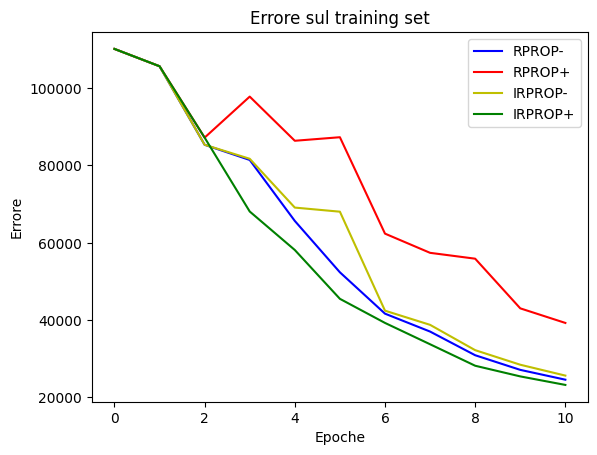

In [6]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore del training
plt.figure()
plt.plot(std_train_err, 'b', label='RPROP-')
plt.plot(plus_train_err, 'r', label='RPROP+')
plt.plot(istd_train_err, 'y', label='IRPROP-')
plt.plot(iplus_train_err, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title('Errore sul training set')
plt.legend()
plt.show()

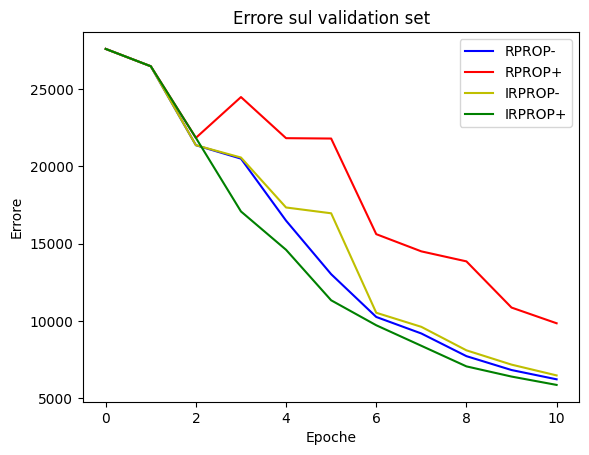

In [7]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore del validation
plt.figure()
plt.plot(std_validation_err, 'b', label='RPROP-')
plt.plot(plus_validation_err, 'r', label='RPROP+')
plt.plot(istd_validation_err, 'y', label='IRPROP-')
plt.plot(iplus_validation_err, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title('Errore sul validation set')
plt.legend()
plt.show()

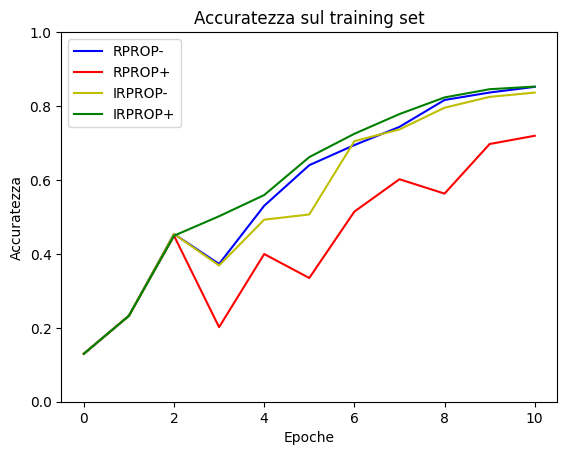

In [8]:
from matplotlib import pyplot as plt

# Stampa grafico della accuracy del training
plt.figure()
plt.plot(std_train_accuracy, 'b', label='RPROP-')
plt.plot(plus_train_accuracy, 'r', label='RPROP+')
plt.plot(istd_train_accuracy, 'y', label='IRPROP-')
plt.plot(iplus_train_accuracy, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title('Accuratezza sul training set')
plt.legend()
plt.ylim(0, 1)
plt.show()

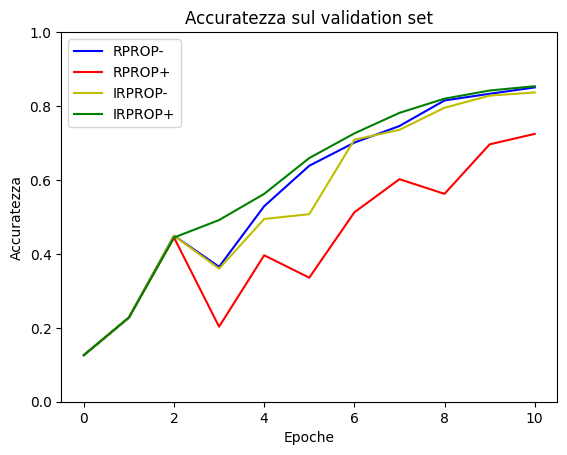

In [9]:
from matplotlib import pyplot as plt

# Stampa grafico della accuracy del validation
plt.figure()
plt.plot(std_validation_accuracy, 'b', label='RPROP-')
plt.plot(plus_validation_accuracy, 'r', label='RPROP+')
plt.plot(istd_validation_accuracy, 'y', label='IRPROP-')
plt.plot(iplus_validation_accuracy, 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title('Accuratezza sul validation set')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [10]:
# Stampa accuracy per training e test set

std_training_net.print_accuracies('Test Rprop-', test_in, test_labels, train_in, train_labels)

Test Rprop-
Test accuracy: 83.65837%
Train accuracy: 85.19344%


In [11]:
# Stampa accuracy per training e test set

plus_training_net.print_accuracies('Test Rprop+', test_in, test_labels, train_in, train_labels)

Test Rprop+
Test accuracy: 69.69697%
Train accuracy: 71.95358%


In [12]:
# Stampa accuracy per training e test set

istd_training_net.print_accuracies('Test iRprop-', test_in, test_labels, train_in, train_labels)

Test iRprop-
Test accuracy: 83.58836%
Train accuracy: 83.63924%


In [13]:
# Stampa accuracy per training e test set

iplus_training_net.print_accuracies('Test iRprop+', test_in, test_labels, train_in, train_labels)

Test iRprop+
Test accuracy: 84.16842%
Train accuracy: 85.26011%


Test Rprop-
Probabilità predette dalla rete:
Classe 0: 0.00792%
Classe 1: 0.22544%
Classe 2: 0.03215%
Classe 3: 0.01933%
Classe 4: 1.80899%
Classe 5: 0.08974%
Classe 6: 0.04778%
Classe 7: 32.88583%
Classe 8: 2.80227%
Classe 9: 62.08055%


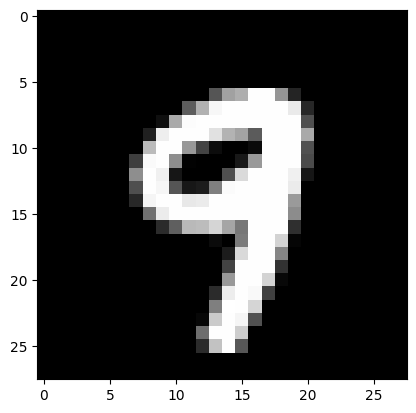

In [14]:
# Predizione rete addestrata con Rprop- (standard)
image = 8000

print('Test Rprop-')
std_training_net.test_prediction(image, test_in)

Test Rprop+
Probabilità predette dalla rete:
Classe 0: 1.47473%
Classe 1: 1.85588%
Classe 2: 5.10222%
Classe 3: 1.33813%
Classe 4: 34.89721%
Classe 5: 1.16662%
Classe 6: 3.60408%
Classe 7: 24.86257%
Classe 8: 12.42679%
Classe 9: 13.27177%


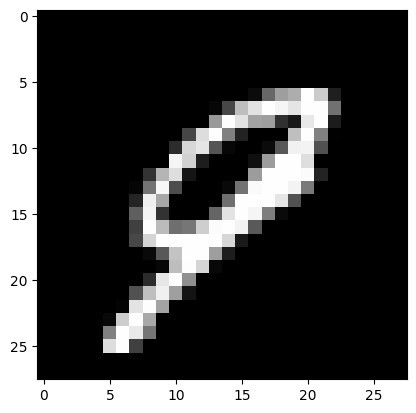

In [15]:
# Predizione rete addestrata con Rprop+ (Rprop con weight-backtracking)
image = 8000

print('Test Rprop+')
plus_training_net.test_prediction(image, test_in)

Test iRprop-
Probabilità predette dalla rete:
Classe 0: 0.0452%
Classe 1: 0.07102%
Classe 2: 0.61784%
Classe 3: 0.2621%
Classe 4: 4.17157%
Classe 5: 0.50243%
Classe 6: 0.64291%
Classe 7: 46.60508%
Classe 8: 12.83087%
Classe 9: 34.25098%


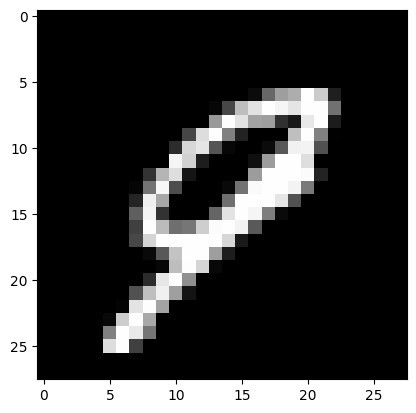

In [16]:
# Predizione rete addestrata con iRprop- (Improved Rprop)
image = 8000

print('Test iRprop-')
istd_training_net.test_prediction(image, test_in)

Test iRprop+
Probabilità predette dalla rete:
Classe 0: 0.00507%
Classe 1: 0.47078%
Classe 2: 0.04763%
Classe 3: 0.28555%
Classe 4: 2.6797%
Classe 5: 0.22461%
Classe 6: 0.03533%
Classe 7: 22.59624%
Classe 8: 19.35291%
Classe 9: 54.30218%


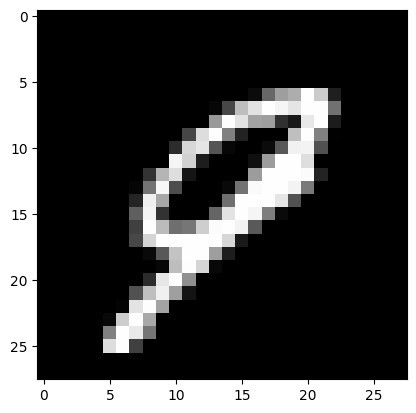

In [17]:
# Predizione rete addestrata con iRprop+ (Improved Rprop con weight-backtracking)
image = 8000

print('Test iRprop+')
iplus_training_net.test_prediction(image, test_in)